In [1]:
import numpy as np
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import pandas as pd
from matplotlib import pyplot as plt
import pickle
from numpy.random import default_rng

In [2]:
seed = 0
np.random.seed(seed)

In [3]:
train_file = 'data/Coffee_TRAIN'

In [4]:
test_file = 'data/Coffee_TEST'

In [14]:
sampling_rate = 2

# Prep Train Data

In [6]:
train_data = np.loadtxt(train_file)

In [7]:
rng = default_rng(12345)
rng.shuffle(train_data)

In [8]:
X_train = train_data[:,1:]

In [9]:
y_train = train_data[:,0]

In [10]:
print(X_train[0])

[10.364243 10.569554 10.448875 10.100696  9.620371  8.882499  8.415529
  8.210217  7.91643   7.806151  7.746734  7.739054  7.825141  7.725533
  7.602954  7.581851  7.518337  7.436305  7.472943  7.561754  7.512576
  7.438912  7.404399  7.229231  7.021992  6.951436  7.01048   7.030379
  6.918896  6.771265  6.698433  6.78838   6.920205  6.981216  7.044445
  7.17612   7.361769  7.554219  7.815139  8.169803  8.502066  8.759834
  9.070481  9.444034  9.633329  9.672459  9.819816 10.049488 10.242047
 10.444507 10.725154 11.181386 11.786936 12.370038 13.061426 13.688799
 14.157277 15.025812 15.794914 16.341785 17.137178 17.1056   16.856855
 17.452514 17.818658 17.731623 18.104903 18.62207  19.071488 19.35683
 19.894282 20.412883 20.248427 20.332815 20.171856 19.693733 19.294176
 18.576514 18.298972 18.293209 18.596757 18.681908 18.426792 18.107913
 17.625184 17.654017 17.632459 17.648564 17.802928 17.955134 17.924891
 17.644847 17.468598 17.441981 16.887715 16.452399 16.47388  16.334339
 15.915

In [11]:
print(y_train)

[0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1.
 0. 1. 1. 0.]


In [12]:
X_train.shape

(28, 286)

In [13]:
y_train.shape

(28,)

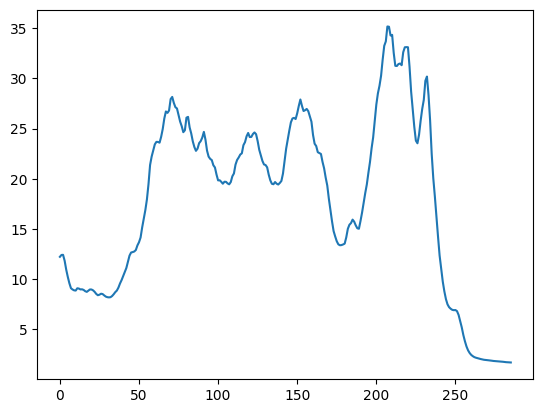

In [15]:
plt.plot(X_train[1])
plt.show()

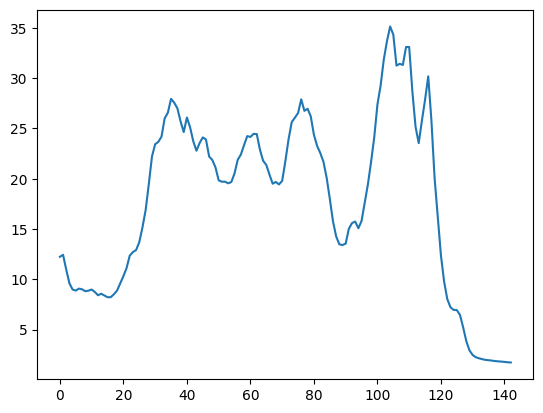

In [16]:
plt.plot(X_train[1, ::sampling_rate])
plt.show()

In [17]:
X_train_sampling = X_train[:, ::sampling_rate]

In [18]:
X_train_sampling.shape

(28, 143)

# Prep Test Data

In [19]:
test_data = np.loadtxt(test_file)

In [20]:
rng = default_rng(12345)
rng.shuffle(test_data)

In [21]:
X_test = test_data[:,1:]

In [22]:
y_test = test_data[:,0]

In [23]:
print(X_test[0])

[21.22762  21.837509 22.729975 22.517663 21.040178 19.256306 18.517982
 18.347773 18.044034 17.735858 17.636301 18.030802 18.234747 18.275447
 17.653334 16.703171 16.23754  16.183836 16.458318 16.580462 16.426112
 16.244503 16.095672 15.756149 15.79169  16.132679 16.508322 16.871483
 16.842656 16.845654 16.634452 16.349113 16.436876 16.491432 16.764196
 16.775461 17.008098 17.836969 18.037436 18.535308 19.58077  20.087088
 20.608749 21.748716 22.715211 23.332629 23.622741 23.518797 23.603404
 24.18692  24.615659 24.570142 24.953235 25.702415 26.156818 26.580045
 28.147476 29.771718 30.680937 31.915029 31.973958 31.624273 31.928091
 31.796528 31.604835 32.380689 33.91842  36.313162 37.153835 36.318143
 36.827345 37.139829 38.123493 38.090543 37.338349 37.202021 36.301432
 35.806015 35.492944 35.662759 36.29706  37.165736 37.303103 36.62438
 35.60524  34.492991 34.01724  33.452682 34.18362  36.215924 36.239584
 36.587565 36.044341 35.025452 34.770565 33.886344 34.510775 34.786302
 34.573

In [24]:
print(y_test[0])

0.0


In [25]:
X_test_sampling = X_test[:, ::sampling_rate]

In [26]:
X_test_sampling.shape

(28, 143)

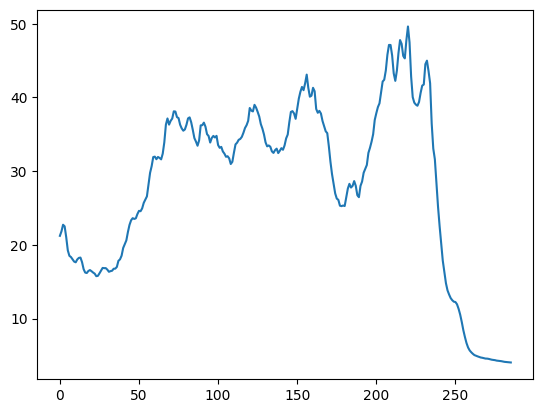

In [27]:
plt.plot(X_test[0])
plt.show()

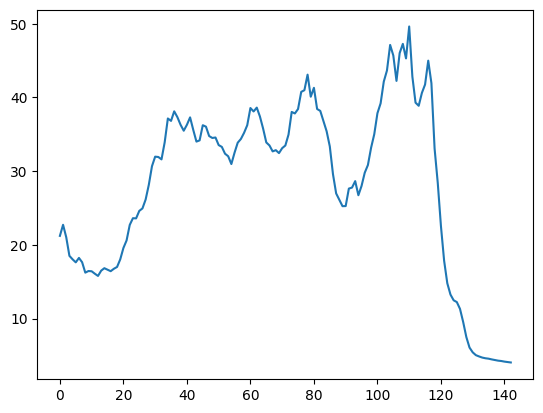

In [28]:
plt.plot(X_test_sampling[0])
plt.show()

# Train Model

In [29]:
def DTW(a, b):
    # ถ้า DTW  ทำช้าอาจต้องทำ sampling เพื่อลดปริมาณ data ทำ DTW จะได้เร็วขึ้น    
    an = a.size
    bn = b.size
    pointwise_distance = distance.cdist(a.reshape(-1,1),b.reshape(-1,1))
    cumdist = np.matrix(np.ones((an+1,bn+1)) * np.inf)
    cumdist[0,0] = 0
    
    for ai in range(an):
        for bi in range(bn):
            minimum_cost = np.min([cumdist[ai, bi+1],
                                   cumdist[ai+1, bi],
                                   cumdist[ai, bi]])
            cumdist[ai+1, bi+1] = pointwise_distance[ai,bi] + minimum_cost

    return cumdist[an, bn]

In [30]:
def DTWWithWeightNeighborCell(a,b,**kwargs):
    # print("weight",kwargs["alpha"],kwargs["beta"],kwargs["gamma"])
    an = a.size
    bn = b.size
    pointwise_distance = distance.cdist(a.reshape(-1,1),b.reshape(-1,1))
    cumdist = np.matrix(np.ones((an+1,bn+1)) * np.inf)
    cumdist[0,0] = 0
    
    for ai in range(an):
        for bi in range(bn):
            minimum_cost = np.min([kwargs["alpha"]*cumdist[ai, bi+1],
                                   kwargs["beta"]*cumdist[ai, bi],
                                   kwargs["gamma"]*cumdist[ai+1, bi]])
            cumdist[ai+1, bi+1] = pointwise_distance[ai,bi] + minimum_cost

    return cumdist[an, bn]

# Test Symmetric Model

In [31]:
clf = KNeighborsClassifier(metric =DTW,n_neighbors=1,n_jobs=-1)
clf.fit(X_train_sampling, y_train)

KNeighborsClassifier(metric=<function DTW at 0x0000024880AD1EA0>, n_jobs=-1,
                     n_neighbors=1)

In [32]:
y_pred = clf.predict(X_test_sampling)

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.92      0.73      0.81        15
         1.0       0.75      0.92      0.83        13

    accuracy                           0.82        28
   macro avg       0.83      0.83      0.82        28
weighted avg       0.84      0.82      0.82        28



# Create Model with weight neighboring cells [Test Asymmetric]

In [34]:
def createMetricParams(alphaMax,betaMax,gammaMax):
    metricParamsArray = []
    for i in range(1,alphaMax+1):
        for j in range(1,betaMax+1):
            for k in range(1,gammaMax+1):
                if (i == k):
                    continue
                metricParam = {"alpha":i,"beta":j,"gamma":k}
                metricParamsArray.append(metricParam)
    return metricParamsArray

In [35]:
createMetricParams(2,2,2)

[{'alpha': 1, 'beta': 1, 'gamma': 2},
 {'alpha': 1, 'beta': 2, 'gamma': 2},
 {'alpha': 2, 'beta': 1, 'gamma': 1},
 {'alpha': 2, 'beta': 2, 'gamma': 1}]

In [36]:
parameters = {'n_neighbors':[1],'metric_params':createMetricParams(5,5,5)}
clf = GridSearchCV(KNeighborsClassifier(metric =DTWWithWeightNeighborCell), parameters, cv=2,verbose=10,n_jobs=-1)
clf.fit(X_train_sampling, y_train)

Fitting 2 folds for each of 100 candidates, totalling 200 fits


GridSearchCV(cv=2,
             estimator=KNeighborsClassifier(metric=<function DTWWithWeightNeighborCell at 0x00000248C45C96C0>),
             n_jobs=-1,
             param_grid={'metric_params': [{'alpha': 1, 'beta': 1, 'gamma': 2},
                                           {'alpha': 1, 'beta': 1, 'gamma': 3},
                                           {'alpha': 1, 'beta': 1, 'gamma': 4},
                                           {'alpha': 1, 'beta': 1, 'gamma': 5},
                                           {'alpha': 1, 'beta': 2, 'gamma': 2},
                                           {'alpha': 1, 'beta': 2, 'gamma': 3},
                                           {'alpha': 1, '...
                                           {'alpha': 1, 'beta': 5, 'gamma': 5},
                                           {'alpha': 2, 'beta': 1, 'gamma': 1},
                                           {'alpha': 2, 'beta': 1, 'gamma': 3},
                                           {'alpha': 2, 'beta': 1, 'gamma': 4},
                                           {'alpha': 2, 'beta': 1, 'gamma': 5},
                                           {'alpha': 2, 'beta': 2, 'gamma': 1},
                                           {'alpha': 2, 'beta': 2, 'gamma': 3},
                                           {'alpha': 2, 'beta': 2, 'gamma': 4},
                                           {'alpha': 2, 'beta': 2, 'gamma': 5},
                                           {'alpha': 2, 'beta': 3, 'gamma': 1},
                                           {'alpha': 2, 'beta': 3, 'gamma': 3}, ...],
                         'n_neighbors': [1]},
             verbose=10)

In [37]:
grid_search_result = clf.cv_results_
grid_search_result_pd = pd.DataFrame.from_dict(grid_search_result)

In [38]:
grid_search_result_pd

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric_params,param_n_neighbors,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001501,5.072355e-04,98.665559,4.208833,"{'alpha': 1, 'beta': 1, 'gamma': 2}",1,"{'metric_params': {'alpha': 1, 'beta': 1, 'gam...",0.785714,0.642857,0.714286,0.071429,1
1,0.001001,6.437302e-06,99.748651,4.992926,"{'alpha': 1, 'beta': 1, 'gamma': 3}",1,"{'metric_params': {'alpha': 1, 'beta': 1, 'gam...",0.785714,0.642857,0.714286,0.071429,1
2,0.000997,2.026558e-06,94.736230,0.305490,"{'alpha': 1, 'beta': 1, 'gamma': 4}",1,"{'metric_params': {'alpha': 1, 'beta': 1, 'gam...",0.785714,0.642857,0.714286,0.071429,1
3,0.001001,1.549721e-06,103.064273,6.703537,"{'alpha': 1, 'beta': 1, 'gamma': 5}",1,"{'metric_params': {'alpha': 1, 'beta': 1, 'gam...",0.785714,0.642857,0.714286,0.071429,1
4,0.000998,3.337860e-06,100.911561,4.325258,"{'alpha': 1, 'beta': 2, 'gamma': 2}",1,"{'metric_params': {'alpha': 1, 'beta': 2, 'gam...",0.642857,0.500000,0.571429,0.071429,45
...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000999,2.145767e-06,107.824431,1.257524,"{'alpha': 5, 'beta': 4, 'gamma': 4}",1,"{'metric_params': {'alpha': 5, 'beta': 4, 'gam...",0.571429,0.571429,0.571429,0.000000,45
96,0.000998,4.768372e-07,85.506386,0.250623,"{'alpha': 5, 'beta': 5, 'gamma': 1}",1,"{'metric_params': {'alpha': 5, 'beta': 5, 'gam...",0.571429,0.500000,0.535714,0.035714,87
97,0.000999,3.576279e-06,84.735492,0.240005,"{'alpha': 5, 'beta': 5, 'gamma': 2}",1,"{'metric_params': {'alpha': 5, 'beta': 5, 'gam...",0.571429,0.500000,0.535714,0.035714,87
98,0.000999,1.430511e-06,83.664330,0.259159,"{'alpha': 5, 'beta': 5, 'gamma': 3}",1,"{'metric_params': {'alpha': 5, 'beta': 5, 'gam...",0.571429,0.500000,0.535714,0.035714,87


In [39]:
grid_search_result_pd[grid_search_result_pd['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric_params,param_n_neighbors,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001501,5.072355e-04,98.665559,4.208833,"{'alpha': 1, 'beta': 1, 'gamma': 2}",1,"{'metric_params': {'alpha': 1, 'beta': 1, 'gam...",0.785714,0.642857,0.714286,0.071429,1
1,0.001001,6.437302e-06,99.748651,4.992926,"{'alpha': 1, 'beta': 1, 'gamma': 3}",1,"{'metric_params': {'alpha': 1, 'beta': 1, 'gam...",0.785714,0.642857,0.714286,0.071429,1
2,0.000997,2.026558e-06,94.736230,0.305490,"{'alpha': 1, 'beta': 1, 'gamma': 4}",1,"{'metric_params': {'alpha': 1, 'beta': 1, 'gam...",0.785714,0.642857,0.714286,0.071429,1
3,0.001001,1.549721e-06,103.064273,6.703537,"{'alpha': 1, 'beta': 1, 'gamma': 5}",1,"{'metric_params': {'alpha': 1, 'beta': 1, 'gam...",0.785714,0.642857,0.714286,0.071429,1
20,0.000500,5.002022e-04,115.330204,1.620773,"{'alpha': 2, 'beta': 1, 'gamma': 1}",1,"{'metric_params': {'alpha': 2, 'beta': 1, 'gam...",0.785714,0.642857,0.714286,0.071429,1
21,0.001001,3.576279e-06,115.882198,0.650010,"{'alpha': 2, 'beta': 1, 'gamma': 3}",1,"{'metric_params': {'alpha': 2, 'beta': 1, 'gam...",0.785714,0.642857,0.714286,0.071429,1
22,0.001499,4.992485e-04,117.338290,1.024484,"{'alpha': 2, 'beta': 1, 'gamma': 4}",1,"{'metric_params': {'alpha': 2, 'beta': 1, 'gam...",0.785714,0.642857,0.714286,0.071429,1
23,0.000998,1.192093e-07,114.882069,0.426264,"{'alpha': 2, 'beta': 1, 'gamma': 5}",1,"{'metric_params': {'alpha': 2, 'beta': 1, 'gam...",0.785714,0.642857,0.714286,0.071429,1
40,0.001001,1.907349e-06,108.235080,0.024300,"{'alpha': 3, 'beta': 1, 'gamma': 1}",1,"{'metric_params': {'alpha': 3, 'beta': 1, 'gam...",0.785714,0.642857,0.714286,0.071429,1
41,0.001495,5.005598e-04,108.093769,0.582390,"{'alpha': 3, 'beta': 1, 'gamma': 2}",1,"{'metric_params': {'alpha': 3, 'beta': 1, 'gam...",0.785714,0.642857,0.714286,0.071429,1


In [40]:
model = clf.best_estimator_

In [41]:
print(model.get_params)

<bound method BaseEstimator.get_params of KNeighborsClassifier(metric=<function DTWWithWeightNeighborCell at 0x00000248C45C96C0>,
                     metric_params={'alpha': 1, 'beta': 1, 'gamma': 2},
                     n_neighbors=1)>


In [42]:
y_pred = model.predict(X_test_sampling)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.67      0.74        15
         1.0       0.69      0.85      0.76        13

    accuracy                           0.75        28
   macro avg       0.76      0.76      0.75        28
weighted avg       0.77      0.75      0.75        28



Dump Best Asym model

In [ ]:
model_file = open('knn_Best_Asym_Coffee.model', 'wb')
pickle.dump(model, model_file)
model_file.close()

จาก db Coffee เราจะเห็นว่า Symmetric (0.82) ดีกว่า Asymmetric (0.75)